# 📘 Hierarchical Clustering on the Cora Dataset

## 1. Introduction

The Cora dataset is a citation network comprising 2,708 scientific publications classified into one of seven classes. Each publication is described by a 0/1-valued word vector indicating the presence or absence of the corresponding word from a dictionary of 1,433 unique words. The citation network consists of 5,429 links.

Hierarchical clustering builds a hierarchy of clusters either in a bottom-up approach (agglomerative) or a top-down approach (divisive). In this tutorial, we'll focus on **Agglomerative Clustering**.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns


## 2. Load the Cora Dataset

The Cora dataset consists of two files:

- `cora.content`: Contains information about each paper (node), including a unique paper ID, a 0/1-valued word vector, and a subject label.
- `cora.cites`: Contains citation relationships (edges) between papers.

You can download the dataset from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).


In [4]:
# Load the content file
column_names = ['paper_id'] + [f'word_{i}' for i in range(1433)] + ['subject']
content = pd.read_csv('cora.content', sep='\t', header=None, names=column_names)

# Extract features and labels
features = content.iloc[:, 1:-1].values
labels = content['subject'].values

# Map subject labels to integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_mapping[label] for label in labels])


In [5]:

print("First 5 rows of cora.content:")
display(content.head())



First 5 rows of cora.content:


,paper_id,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,...,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [6]:
# Explanation: We convert the string subject labels into numerical integers.
# This is necessary for evaluation metrics like NMI and ARI, which work with numerical labels.
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_mapping[label] for label in labels])

print("Cora content dataset loaded.")
print(f"Number of papers: {features.shape[0]}")
print(f"Number of features per paper: {features.shape[1]}")
print(f"Number of distinct subjects: {len(label_mapping)}")


Cora content dataset loaded.
Number of papers: 2708
Number of features per paper: 1433
Number of distinct subjects: 7


## 3. Dimensionality Reduction with PCA

To visualize the data and for computational efficiency, we'll reduce the dimensionality of the feature vectors using Principal Component Analysis (PCA).


In [7]:
# We use Principal Component Analysis (PCA) to reduce the high-dimensional
# feature vectors (1433 dimensions) to a lower number of dimensions (50).
# This makes the clustering computationally more efficient and can sometimes help
# by focusing on the most important variance in the data.
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

print(f"Features reduced to {reduced_features.shape[1]} dimensions using PCA.")

# Explanation: We further reduce the features to 2 dimensions specifically for visualization.
# This 2D representation is used to plot the clusters in a scatter plot.
pca_2d = PCA(n_components=2)
reduced_features_2d = pca_2d.fit_transform(features)


Features reduced to 50 dimensions using PCA.


## 5. Perform Agglomerative Clustering




In [8]:
# Explanation: We instantiate the AgglomerativeClustering model from scikit-learn.
# We set n_clusters to 7 because we know there are 7 true subject categories.
# metric='euclidean' specifies the distance used between data points.
# linkage='ward' determines how the distance between clusters is calculated during merging.
# CRUCIAL: No 'connectivity' parameter is provided, so the clustering only considers feature similarity.
n_clusters = 7 # Based on the number of subjects in the dataset

agg_clustering_content = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)

# Explanation: We fit the clustering model to the reduced features and predict the cluster
# label for each paper.
cluster_labels_content = agg_clustering_content.fit_predict(reduced_features)

print(f"Content-based agglomerative clustering performed, {n_clusters} clusters found.")

Content-based agglomerative clustering performed, 7 clusters found.


## 6. Visualize the Clustering Results


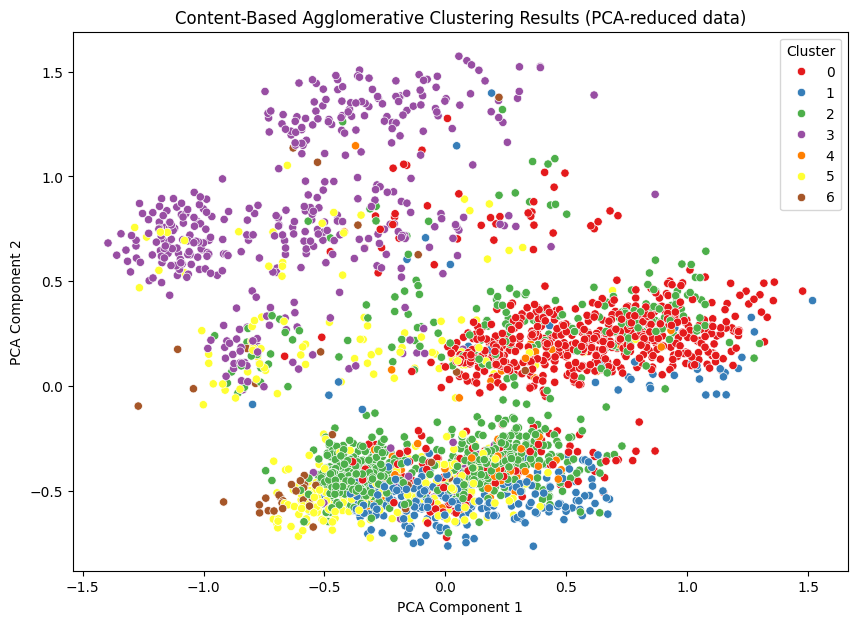

In [9]:
#Explanation: We create a pandas DataFrame containing the 2D PCA components,
# the predicted cluster labels, and the true subject labels for plotting.
df_viz_content = pd.DataFrame()
df_viz_content['PCA1'] = reduced_features_2d[:, 0]
df_viz_content['PCA2'] = reduced_features_2d[:, 1]
df_viz_content['Cluster'] = cluster_labels_content
df_viz_content['True Label'] = numeric_labels # Using integer labels for plotting color mapping

# Explanation: We generate a scatter plot using seaborn, where each point is a paper
# plotted in the 2D PCA space. The color of each point represents its assigned cluster.
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_viz_content, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', legend='full')
plt.title("Content-Based Agglomerative Clustering Results (PCA-reduced data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

## 7. Evaluate Clustering Performance

We'll use **Normalized Mutual Information (NMI)** and **Adjusted Rand Index (ARI)** to evaluate the clustering performance.


In [10]:
# Explanation: We evaluate how well the obtained clusters match the true subject labels
# using Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI).
# NMI and ARI measure the similarity between two different clusterings (our predicted clusters
# and the true subjects), accounting for chance. Higher values (closer to 1.0) indicate better agreement.
nmi_content = normalized_mutual_info_score(numeric_labels, cluster_labels_content)
ari_content = adjusted_rand_score(numeric_labels, cluster_labels_content)

print("\nContent-based Clustering Performance Evaluation:")
print(f"Normalized Mutual Information (NMI): {nmi_content:.3f}")
print(f"Adjusted Rand Index (ARI): {ari_content:.3f}")


Content-based Clustering Performance Evaluation:
Normalized Mutual Information (NMI): 0.188
Adjusted Rand Index (ARI): 0.102


Code 2: Hierarchical Clustering With Graph Awareness (Content + Connectivity)

This code incorporates the citation network structure to constrain the hierarchical clustering process.

The key idea for graph-based agglomerative clustering in scikit-learn is to use the connectivity parameter of the AgglomerativeClustering class. This parameter takes a matrix (typically the adjacency matrix of your graph) that constrains which points can be merged. Only pairs of points connected by an edge in the connectivity matrix will be considered for merging into a new cluster.

Cora dataset loaded.
Citation graph built and connectivity matrix generated.
Features reduced to 50 dimensions using PCA.


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Graph-aware agglomerative clustering performed, 7 clusters found.

Graph-aware Clustering Performance Evaluation:
Normalized Mutual Information (NMI): 0.389
Adjusted Rand Index (ARI): 0.258


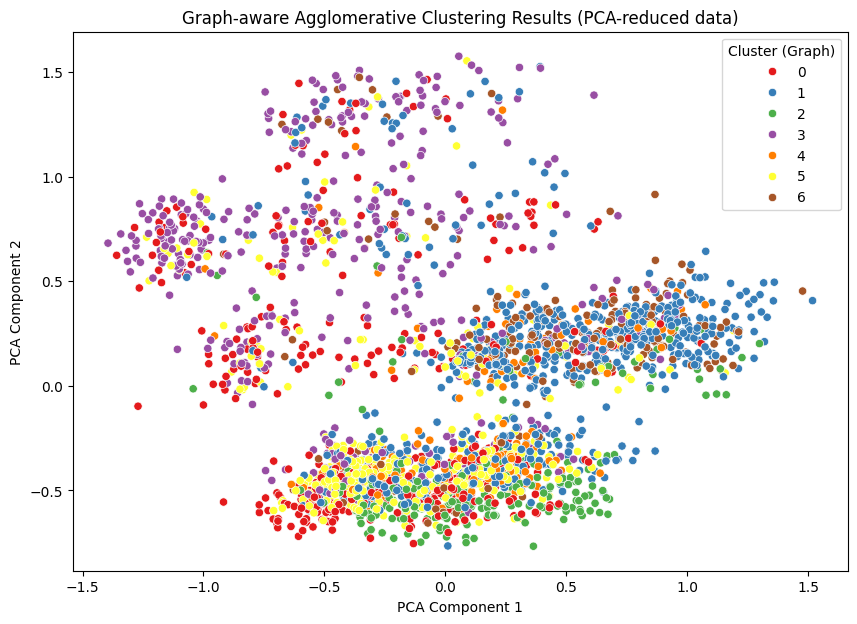

In [12]:
import pandas as pd
import networkx as nx # For graph manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering # For hierarchical clustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score # For evaluation
from sklearn.decomposition import PCA # For dimensionality reduction
from scipy.sparse import csr_matrix # To handle sparse matrices

# --- 1. Load the Cora Dataset (Content and Cites Files) ---
# Explanation: We load the 'cora.content' file to get paper features and true labels.
column_names = ['paper_id'] + [f'word_{i}' for i in range(1433)] + ['subject']
content = pd.read_csv('cora.content', sep='\t', header=None, names=column_names)

# Explanation: We extract paper IDs, features, and true labels. We need paper_ids
# to link the content data to the citation data.
paper_ids = content['paper_id'].values
features = content.iloc[:, 1:-1].values
labels = content['subject'].values

# Explanation: We convert subject labels to integers for evaluation.
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_mapping[label] for label in labels])

print("Cora dataset loaded.")

# Explanation: We load the 'cora.cites' file which lists the citation relationships (edges).
cites = pd.read_csv('cora.cites', sep='\t', header=None, names=['source', 'target'])

# Explanation: We build a NetworkX directed graph from the citation data.
G = nx.from_pandas_edgelist(cites, source='source', target='target', create_using=nx.DiGraph())

# Explanation: We ensure that all papers listed in the content file are present as nodes in the graph,
# even if they have no citations (isolated nodes).
all_paper_ids = set(paper_ids)
graph_nodes = set(G.nodes())
nodes_to_add = list(all_paper_ids - graph_nodes)
G.add_nodes_from(nodes_to_add)

# Explanation: We create an undirected graph and ensure the order of nodes in the graph
# matches the order of papers in the 'content' DataFrame and the 'features' array.
# This alignment is crucial so that the rows/columns of the connectivity matrix
# correspond correctly to the rows of the features array.
G_ordered = nx.Graph() # Use undirected for symmetric connectivity
G_ordered.add_nodes_from(paper_ids) # Add nodes in the desired order
G_ordered.add_edges_from(G.edges()) # Add existing edges

# Explanation: We get the adjacency matrix of the ordered graph as a sparse matrix.
# This matrix represents the connectivity of the graph.
connectivity = nx.adjacency_matrix(G_ordered, nodelist=list(G_ordered.nodes()))

# Explanation: We explicitly ensure the connectivity matrix is in a CSR sparse format,
# which is commonly used and compatible with scikit-learn's AgglomerativeClustering.
if not isinstance(connectivity, csr_matrix):
     connectivity = csr_matrix(connectivity)

print("Citation graph built and connectivity matrix generated.")

# --- 2. Dimensionality Reduction with PCA ---
# Explanation: We reduce the dimensionality of the content features using PCA,
# same as in the content-based clustering. This is the data the clustering
# algorithm will measure distances on, but the merges will be constrained by connectivity.
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

print(f"Features reduced to {reduced_features.shape[1]} dimensions using PCA.")

# Explanation: Reduce features to 2D for visualization.
pca_2d = PCA(n_components=2)
reduced_features_2d = pca_2d.fit_transform(features)


# --- 3. Perform Graph-aware Agglomerative Clustering ---
# Explanation: We instantiate the AgglomerativeClustering model.
# n_clusters, metric, and linkage are set as before.
# CRUCIAL: We provide the 'connectivity' matrix. This parameter ensures that
# the clustering algorithm only considers merging two clusters if there is at least
# one edge in the graph connecting a node in one cluster to a node in the other.
n_clusters = 7 # Number of expected clusters (subjects)

agg_clustering_graph = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean', # Metric applied to the reduced_features
    linkage='ward',     # Linkage strategy
    connectivity=connectivity # Constrain merges using the graph structure
)

# Explanation: We fit the clustering model to the reduced features. The connectivity matrix
# is used internally to restrict the valid merges.
cluster_labels_graph = agg_clustering_graph.fit_predict(reduced_features)

print(f"Graph-aware agglomerative clustering performed, {n_clusters} clusters found.")

# --- 4. Evaluate Clustering Performance (Graph-aware) ---
# Explanation: We evaluate the graph-aware clusters against the true subject labels
# using NMI and ARI.
nmi_graph = normalized_mutual_info_score(numeric_labels, cluster_labels_graph)
ari_graph = adjusted_rand_score(numeric_labels, cluster_labels_graph)

print("\nGraph-aware Clustering Performance Evaluation:")
print(f"Normalized Mutual Information (NMI): {nmi_graph:.3f}")
print(f"Adjusted Rand Index (ARI): {ari_graph:.3f}")

# --- 5. Visualize the Clustering Results (Graph-aware, using 2D PCA) ---
# Explanation: Create a DataFrame for visualization with graph cluster labels.
df_viz_graph = pd.DataFrame()
df_viz_graph['PCA1'] = reduced_features_2d[:, 0]
df_viz_graph['PCA2'] = reduced_features_2d[:, 1]
df_viz_graph['Cluster (Graph)'] = cluster_labels_graph
df_viz_graph['True Label'] = numeric_labels # Using integer labels for plotting color mapping

# Explanation: Generate a scatter plot showing the graph-aware clusters in 2D PCA space.
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_viz_graph, x='PCA1', y='PCA2', hue='Cluster (Graph)', palette='Set1', legend='full')
plt.title("Graph-aware Agglomerative Clustering Results (PCA-reduced data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster (Graph)')
plt.show()